In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import pandas as pd

# Научное программирование -- Последовательность-в-последовательность (Sequence-to-Sequence, seq2seq)
Рекуррентные нейронные сети обрабатывают последовательности. Однако, возникают задачи связанные с тем, чтоб одну последовательность преобразовать в другую.
Например, машинный перевод с одного языка на другой. Для этого используется специальная модель последовательность-в-последовательность (Sequence-to-Sequence, seq2seq).

Вспомним базовую архитектуру рекуррентной нейронной сети.     

![Последовательность-в-последовательность](images/rnn-basic.png)

Рассмотрим многослойную рекуррентную сеть.      
![Последовательность-в-последовательность](images/rnn-basic-stacked.png)

Посмотрим на архитектуру Последовательность-в-последовательность

![Последовательность-в-последовательность](images/seq2seq.png)

В оригинальной форме представляет из себя 2 рекуррентные сети работающие одна после другой:
* Сеть-Кодировщик -- принимает на вход оригинальную последовательность $x^{<1>}, ..., x^{<t>}$, преобразует ее в некоторое скрытое состояние $h^{<t>}$
* Сеть-Декодер -- ининциализирует свое скрытое состояние, используя вычисленное $h^{<t>}$, занимается выводом нужной последовательности

Работа декодера заключается в предсказании на каждом шаге вывода последовательности следующего элемента.  
Затем, предсказанный элемент подается как следующий элемент последовательности, из него выводится новый элемент и так далее.

В качестве начального элемента последовательности декодеру подается специальное значение начала последовательности -- BOS (Begin-of-Sequence). Из него, в зависимости от скрытого состояния, происходит вывод последующих элементов до тех пор, пока длина последовательности не достигнет максимального значения, либо не будет предсказан другое специальное значение, обозначающее конец последовательности -- EOS (End-of-Sequence).

$y$ -- набор символов алфавита (включая служебные).

$p(y^{<t'>} | y^{<t'-1>}, ...,y^{<1>}, h^{<t>} )$ -- распределение вероятностей появления символа в последовательности для момента $<t'>$, при условии что до этого были выведены символы $y^{<t'-1>}, ..., y^{<1>}$,
а закодированная информация о последовательности равна $h^{<t>}$.

Существуют разные стратегии вывода последовательности, но будем использовать самую простую -- жадную.

$y^{<t>} = \underset{y}{argmax}\, {p(y^{<t'>} | y^{<t'-1>}, ...,y^{<1>}, h^{<t>} )}$

Условно, каждый шаг декодера происходит решение задачи классификации => используется Softmax и Кросс-энтропия

Исходные данные могут потребовать модификации, в зависимости от решаемой задачи. Максимальная длина исходной последовательности фиксируется некоторым значением (заранее выбранным). В случае, если последовательность в наборе данных меньше этой максимальной длины, конец заполняется EOS. В начало исходной последовательности может быть добавлен BOS. Длина конечной последовательности также обычно ограничивается некоторым значением.    

#### Тренировочный набор данных:

Двоичные числа от $0$ до $2^{seq\_len} - 1$. Входной алфавит: 0, 1. Выходной: 0-9. Доп. символы: начало последовательности - \$, конец последовательности - \^.

#### Задача:
Используя модель последовательность-в-последовательность преобразовывать двоичные числа в десятичные.

In [2]:
bos_token = '$'
eos_token = '^'

In [3]:
input_alphabet = '$^01'
output_alphabet = '$^0123456789'

Положим $target\_seq\_len$ равным 16

In [4]:
max_len_input = 16
max_len_output = 5

In [5]:
vals = []
gts = []
for i in range(0, int('0b' + ''.join( ['1' for x in range(0, max_len_input)]), base=2)):
    #gt = [bos_token] + [int(x) for x in list(bin(i)[2:])]
    cur_val = [x for x in list(bin(i)[2:])]
    cur_val += (max_len_input - len(cur_val))*[eos_token]
    gt = [x for x in str(i)]
    gt += (max_len_output - len(gt))*[eos_token]
    vals.append(cur_val)
    gts.append(gt)
vals = np.array(vals)
gts = np.array(gts)

Выберем случайно 1000 элементов из набора данных (для уменьшения времени, затрачиваемого при обучении за 1 эпоху)

In [6]:
data_size = 1000

In [7]:
np.random.seed(42)
data_idx = np.random.choice(range(0, vals.shape[0]), size=data_size, replace=False)
data = vals[data_idx][..., None]
data_gt = gts[data_idx][..., None]

In [8]:
''.join(data_gt[5].squeeze()), ''.join(data[5].squeeze())

('48234', '1011110001101010')

In [9]:
data_whole = vals[..., None]

In [10]:
data_whole.shape

(65535, 16, 1)

In [11]:
data.shape

(1000, 16, 1)

In [12]:
for i in range(0, 10):
    print(data[i].squeeze())

['1' '1' '1' '1' '0' '1' '1' '0' '1' '0' '0' '1' '0' '1' '1' '0']
['1' '0' '1' '0' '0' '0' '0' '0' '1' '0' '0' '0' '1' '1' '1' '1']
['1' '1' '1' '1' '1' '0' '0' '1' '0' '1' '0' '1' '^' '^' '^' '^']
['1' '0' '0' '1' '0' '0' '0' '1' '0' '1' '0' '1' '1' '1' '0' '1']
['1' '1' '1' '0' '1' '1' '1' '1' '1' '0' '0' '1' '0' '0' '1' '^']
['1' '0' '1' '1' '1' '1' '0' '0' '0' '1' '1' '0' '1' '0' '1' '0']
['1' '1' '1' '1' '1' '1' '0' '1' '1' '0' '0' '1' '1' '1' '^' '^']
['1' '1' '0' '0' '0' '1' '1' '0' '1' '0' '0' '1' '1' '1' '1' '1']
['1' '1' '1' '0' '1' '0' '1' '0' '0' '0' '^' '^' '^' '^' '^' '^']
['1' '1' '1' '1' '1' '0' '1' '0' '0' '0' '0' '0' '0' '0' '1' '1']


In [13]:
data_gt[5]

array([['4'],
       ['8'],
       ['2'],
       ['3'],
       ['4']], dtype='<U1')

In [14]:
epochs_num = 100

Предварительно перед тем как подавать последовательность в сеть, заменим символы на их соответствующие позиции в алфавите.

In [15]:
def transform_to_tensor(arr):
    positions_list = []
    for c in arr:
        positions_list.append([output_alphabet.find(c[0])])
    return torch.LongTensor(positions_list)

In [16]:
transform_to_tensor(data_gt[5])

tensor([[ 6],
        [10],
        [ 4],
        [ 5],
        [ 6]])

Последовательность будем кодировать в виде векторов при помощи унитарных кодов (one-hot).    
Размер вектора = размеру **всего** алфавита (включая спец. символы).   
Преобразование для входной последовательности выполним тривиально, создадим вектор из четырех нулей, в соответствующую позицию поставим 1.

In [17]:
def transform_input(pos):
    ret_tens = torch.zeros((1, len(input_alphabet)), dtype=torch.float32)
    ret_tens[:, pos] = 1.
    return ret_tens

In [18]:
def transform_output(pos):
    ret_tens = torch.zeros((1, len(output_alphabet)), dtype=torch.float32)
    ret_tens[:, pos] = 1.
    return ret_tens
   

In [19]:
print(transform_input(0),transform_input(1), transform_input(2), transform_input(3))

tensor([[1., 0., 0., 0.]]) tensor([[0., 1., 0., 0.]]) tensor([[0., 0., 1., 0.]]) tensor([[0., 0., 0., 1.]])


In [20]:
print(transform_output(0), transform_output(1), transform_output(8), transform_output(9))

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]) tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]) tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]]) tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])


Данная функция переводит последовательность позиций обратно в последовательность символов:

In [21]:
def convert_to_symb_seq(seq):
    res = []
    for el in seq:
        res.append(output_alphabet[el])
    return np.array(res)

Для оценки качества будем использовать [расстояние Хэмминга](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%A5%D1%8D%D0%BC%D0%BC%D0%B8%D0%BD%D0%B3%D0%B0) -- число позиций, в которых соответствующие символы двух слов одинаковой длины различны.

In [22]:
def hamming_metric(true_output, output): 
    v = true_output != output
    return torch.sum(v).item()

#### Реализация

Возьмем LSTM из прошлой лекции

Состояние ячейки для декодера, аналогично скрытому состоянию, берется из последнего значения из кодировщика.

In [23]:
class LSTM(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        
        self.forget_gate_x = nn.Linear(input_size, hidden_size, bias=True)
        self.forget_gate_h = nn.Linear(hidden_size, hidden_size, bias=True)
        
        self.input_gate_x = nn.Linear(input_size, hidden_size, bias=True)
        self.input_gate_h = nn.Linear(hidden_size, hidden_size, bias=True)
        
        self.cell_gate_x = nn.Linear(input_size, hidden_size, bias=True)
        self.cell_gate_h = nn.Linear(hidden_size, hidden_size, bias=True)
        
        self.output_gate_x = nn.Linear(input_size, hidden_size, bias=True)
        self.output_gate_h = nn.Linear(hidden_size, hidden_size, bias=True)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
        self.hy = nn.Linear(hidden_size, output_size, bias=True)
        
    def forward(self, x, last_hidden, last_cell_state):
        f_t = self.sigmoid(self.forget_gate_x(x) + self.forget_gate_h(last_hidden))
        i_t = self.sigmoid(self.input_gate_x(x) + self.input_gate_h(last_hidden))
        g_t = self.tanh(self.cell_gate_x(x) + self.cell_gate_h(last_hidden))
        o_t = self.sigmoid(self.output_gate_x(x) + self.output_gate_h(last_hidden))
        
        c_t = f_t * last_cell_state + i_t * g_t
        h_t = o_t * self.tanh(c_t)
        y_t = self.hy(h_t)
        
        return h_t, c_t, y_t

In [24]:
class EncoderDecoder(nn.Module):
    
    def __init__(self, input_seq_vec_size, output_seq_vec_size, hidden_size, max_input_seq_len, max_output_seq_len):
        super(EncoderDecoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.max_input_seq_len = max_input_seq_len
        self.max_output_seq_len = max_output_seq_len
                
        self.hiddens_encoder = None
        self.cells_encoder = None
        self.encoder = LSTM(input_seq_vec_size, hidden_size, input_seq_vec_size)
        
        self.hiddens_decoder = None
        self.cells_decoder = None
        self.decoder = LSTM(output_seq_vec_size, hidden_size, output_seq_vec_size)       
     
    def forward(self, x):
        t = 0 
        #Подаем оригинальную последовательность в кодировщик
        for t in range(1, self.max_input_seq_len + 1):
            x_t = x[:,t - 1]
            #Превращаем исходный элемент последовательности в one-hot вектор
            x_t_t = transform_input(x_t)
            self.hiddens_encoder[t], self.cells_encoder[t], _ = self.encoder(x_t_t, self.hiddens_encoder[t-1], self.cells_encoder[t-1])
            #Если встретили EOS (^) => прекращаем проход по последовательности
            if (x_t == 1): 
                break
            
        predictions = []
        #Подаем декодеру BOS ($) в one-hot форме
        bos_token_torch = transform_output(0)
        #и берем для первого шага декодера, в качестве начального значения скрытого состояния
        #последнее полученное значение скрытого состояния из кодировщика.
        self.hiddens_decoder[1], self.cells_decoder[1], res = self.decoder(bos_token_torch, self.hiddens_encoder[t], self.cells_encoder[t])
        #Выбираем следующий символ
        tok = self.get_next_token(res)
        #Из-за особенностей реализации CrossEntropyLoss в PyTorch в качестве выхода из сети
        #будем выдавать массив из ненормированных "очков" для каждого шага вывода выходной последовательности,
        #вывод которой производит декодер.
        predictions.append(res)
        #Выводим всю последовательность, предполагая что ее длина всегда будет max_output_seq_len.
        #"Лишние" элементы сеть добьет EOS (^)
        for t in range(2, self.max_output_seq_len + 1):
            #One-hot:
            tok = transform_output(tok)
            #Вывод элемента, который будет получен на текущем шаге:
            self.hiddens_decoder[t], self.cells_decoder[t], res = self.decoder(tok, self.hiddens_decoder[t-1], self.cells_decoder[t-1])
            tok = self.get_next_token(res)
            #Сохраняем "очки", выдаваемые декодером
            predictions.append(res)
            
        return predictions
    
    #Используем жадную стратегию выбора следующего символа.
    #Выбираем символ (вернее соотвествующую ему позицию в алфавите) с наибольшей вероятностью из всех.
    def get_next_token(self, probs):
        pr = F.softmax(probs, dim=-1)
        tok = torch.argmax(pr, dim=-1)
        return tok
    
    #Перед обработкой каждой последовательности вызываем данную функцию для сброса скрытых состояний и состояний ячеек.
    def reset_states(self):
        self.hiddens_encoder = [torch.zeros(1, self.hidden_size, dtype=torch.float32, requires_grad=True) for t in range(0, self.max_input_seq_len + 1)]
        self.cells_encoder = [torch.zeros(1, self.hidden_size, dtype=torch.float32, requires_grad=True) for t in range(0, self.max_input_seq_len + 1)]
        self.hiddens_decoder = [torch.zeros(1, self.hidden_size, dtype=torch.float32, requires_grad=True) for t in range(0, self.max_output_seq_len + 1)]
        self.cells_decoder = [torch.zeros(1, self.hidden_size, dtype=torch.float32, requires_grad=True) for t in range(0, self.max_output_seq_len + 1)]
        
        

In [25]:
#Фиксируем рандом и инициализируем сеть
np.random.seed(42)
torch.manual_seed(42)
model = EncoderDecoder(4, 12, 64, max_len_input, max_len_output)
for w in model.parameters():
    torch.nn.init.uniform_(w.data, -1., 1.)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(reduction='mean')

model.train()

loss_log = []
metric_log = []
with trange(epochs_num) as epoch_bar:
    for e in epoch_bar:
        total_loss = 0
        total_metric = 0
        #Используется стохастический градиентный спуск (модификация Adam, так как сеть лучше с ним учится, нежели чем с обычным SGD)
        for i in range(0, data.shape[0]):
            optimizer.zero_grad()
            model.reset_states()
         
            #Выбираем последовательности из набора данных.
            x_s = data[i]
            y_s = data_gt[i]
            #Приводим их к формату, который на вход примет сеть.
            y_s = transform_to_tensor(y_s)[None, :, 0]
            x_s = transform_to_tensor(x_s)[None, ...]
        
            predictions = model(x_s)
            #Превращаем список с очками для каждого в PyTorch-тензор, который можно подать в criterion.
            preds = torch.cat(predictions)
            preds = preds.transpose(1, 0)
            preds = preds.unsqueeze(0)
            
            l_t = criterion(preds, y_s)
            l_t.backward()
            
            #Конвертируем полученный список с очками в последовательность из позиций для расчета метрики.
            predicted_seq = []
            preds = preds.squeeze().transpose(1, 0)
            for t in preds:
                predicted_seq.append(torch.argmax(t).item())
                
            cur_metric = hamming_metric(y_s.squeeze(), torch.LongTensor(predicted_seq))
            total_metric += cur_metric
            hidden_store_row = {}
            
            total_loss += l_t.detach().item()
            optimizer.step()
            epoch_bar.set_postfix({'Loss': total_loss / (i + 1), 'Hamming': total_metric / (i+1)})

        loss_log.append(total_loss/ data.shape[0])
        metric_log.append(total_metric/data.shape[0])
        epoch_bar.set_postfix({'Avg_loss':total_loss/ data.shape[0], 'Avg_Hamming': total_metric / data.shape[0]})


100%|█████████████████████████████████████████████| 100/100 [27:55<00:00, 16.76s/it, Avg_loss=0.267, Avg_Hamming=0.375]


Поведение функции потерь:

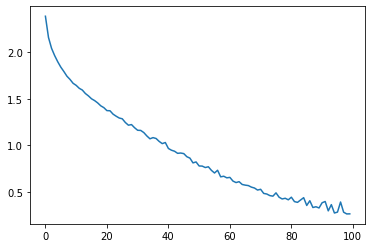

In [26]:
plt.plot(loss_log) 

Поведение метрики:

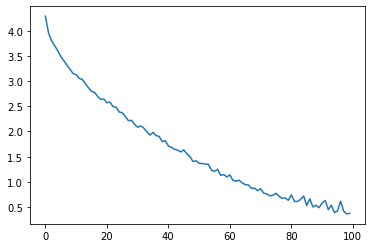

In [27]:
plt.plot(metric_log) 

Запустим обученную сеть на первых 10 элементах из обучающей выборки:

In [28]:
#Код аналогичен обучению, за исключением того, что 
#здесь также сохраняется скрытое состояние на выходе 
#из кодировщика.
total_loss = 0
total_metric = 0
model.eval()
inference_logging_cols = ['input_seq','target_seq', 'predict', 'encoding']
inference_log = pd.DataFrame(columns=inference_logging_cols)
for i in range(0, 10):
    model.reset_states()

    x_s = data[i]
    y_s = data_gt[i]
    y_s = transform_to_tensor(y_s)[None, :, 0]
    x_s = transform_to_tensor(x_s)[None, ...]

    predictions = model(x_s)
    preds = torch.cat(predictions, axis=0).view(-1, 12)
    preds = preds.unsqueeze(0)
    
    #Ищем последнее скрытое состояние
    enc_pos = np.argmax(x_s.squeeze() == 1).item()
    if enc_pos == 0: #Исходная последовательность состоит из 16 элементов
        encoding = model.hiddens_encoder[-2]
    else: #Исходная последовательность меньше 16 элементов
        encoding = model.hiddens_encoder[enc_pos - 1]
        
    predicted_seq = []
    for t in preds.squeeze():
        predicted_seq.append(torch.argmax(t).item())

    log_row = {}
    log_row['input_seq'] = data[i].squeeze()
    log_row['target_seq'] = data_gt[i].squeeze()
    log_row['predict'] = convert_to_symb_seq(predicted_seq)
    log_row['encoding'] =  encoding.detach().numpy()
    
    inference_log = inference_log.append(log_row, ignore_index=True)
    total_metric += 0

    total_loss += l_t.detach().item()
    optimizer.step()
    epoch_bar.set_postfix({'Loss': total_loss / (i + 1), 'Hamming': total_metric / (i+1)})

In [29]:
inference_log

,input_seq,target_seq,predict,encoding
0,"[1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0]","[6, 3, 1, 2, 6]","[6, 3, 1, 2, 6]","[[-0.75427663, -0.0074449973, -0.82325786, 0.3..."
1,"[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1]","[4, 1, 1, 0, 3]","[4, 1, 1, 0, 3]","[[-0.0010475502, 0.98377836, -0.031752992, -0...."
2,"[1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, ^, ^, ^, ^]","[3, 9, 8, 9, ^]","[3, 9, 8, 9, ^]","[[-0.40016663, -0.04315175, -0.49926862, 0.011..."
3,"[1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1]","[3, 7, 2, 1, 3]","[3, 7, 2, 1, 3]","[[-0.44533226, -0.00087148626, -0.32129282, 0...."
4,"[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, ^]","[3, 0, 6, 6, 5]","[3, 0, 6, 6, 5]","[[0.62455994, -0.013303289, -0.7389897, 0.5308..."
5,"[1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0]","[4, 8, 2, 3, 4]","[4, 8, 2, 3, 4]","[[-0.010636857, 0.80931604, 0.13217135, 0.0714..."
6,"[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, ^, ^]","[1, 6, 2, 3, 1]","[1, 6, 2, 3, 1]","[[0.75156003, -0.055901427, -0.33202907, 0.043..."
7,"[1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]","[5, 0, 8, 4, 7]","[5, 0, 7, 4, 7]","[[-0.013047562, 0.96768063, 0.3243662, 0.84980..."
8,"[1, 1, 1, 0, 1, 0, 1, 0, 0, 0, ^, ^, ^, ^, ^, ^]","[9, 3, 6, ^, ^]","[9, 3, 6, ^, ^]","[[-0.72355765, 0.004354641, -0.33199337, 0.291..."
9,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1]","[6, 4, 0, 0, 3]","[6, 4, 0, 0, 3]","[[-0.5917173, -0.058984786, -0.2470993, 0.2175..."


Отрисуем исходные и получаемые последовательности, а также кодировку исходной последовательности из кодировщика:

In [30]:
def draw_vector(vec1, vec2):
    fig, axs = plt.subplots(2, 1,figsize=(17,2), sharex=True)
    vec1_cod = []
    vec2_cod = []
    for c in vec1:
        vec1_cod.append(output_alphabet.find(c))
    for c in vec2:
        vec2_cod.append(output_alphabet.find(c))
    vec1_cod = np.array(vec1_cod)[None, ...]
    vec2_cod = np.array(vec2_cod)[None, ...]
    for i in range(0, 2):
        axs[i].tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelleft=False) # labels along the bottom edge are off
    axs[0].set_xticks(np.arange(-0.5, max_len_output-1, 1))
    axs[0].set_xticklabels(range(0, max_len_output))
    axs[0].imshow(vec1_cod, cmap='Pastel1', aspect = "auto",vmin=0,vmax=11)
    axs[1].imshow(vec2_cod, cmap='Pastel1', aspect = "auto",vmin=0,vmax=11)
    axs[0].text(-1, 0, 'Gt:')
    axs[1].text(-1, 0, 'Pred:')
    for i in range(0, max_len_output):
        axs[0].text(i, 0, vec1[i], fontsize=16)
    for i in range(0, max_len_output):
        axs[1].text(i, 0, vec2[i], fontsize=16)        
    for i in range(0, 2):
        axs[0].grid(axis='x', color='black')
        axs[1].grid(axis='x', color='black')
    fig.subplots_adjust(hspace=0)
    return fig, axs

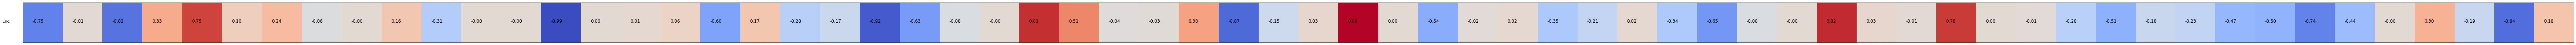

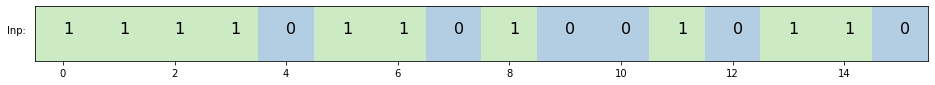

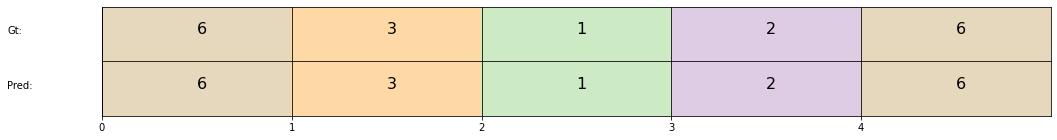

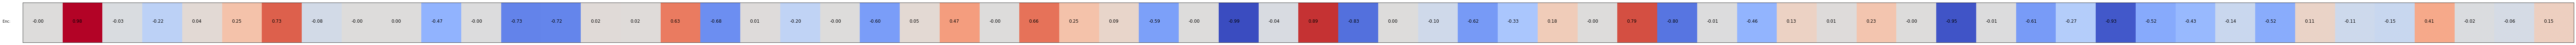

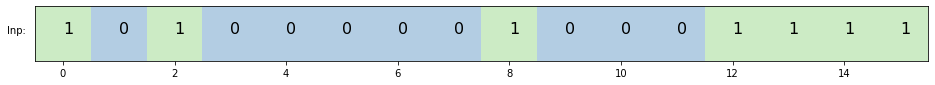

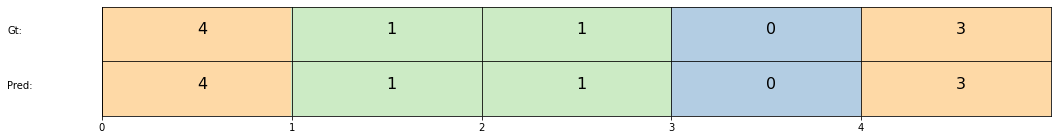

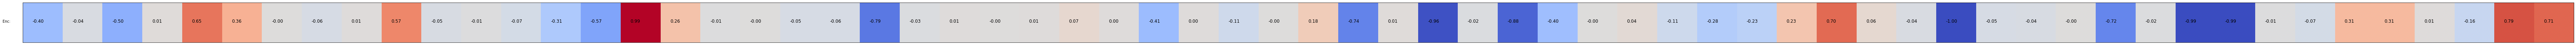

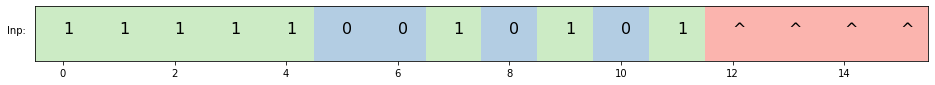

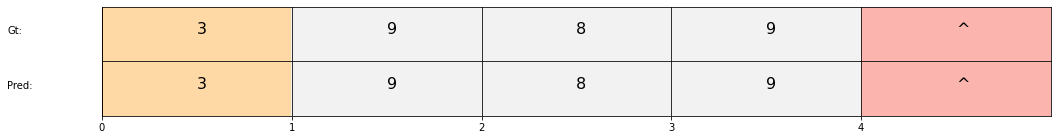

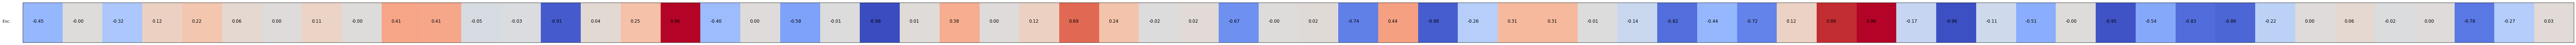

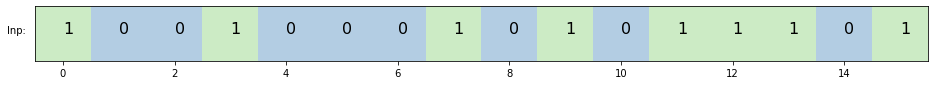

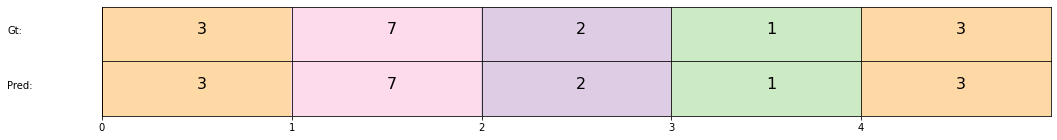

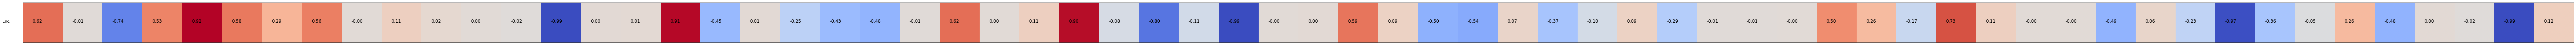

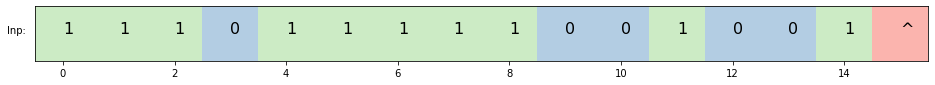

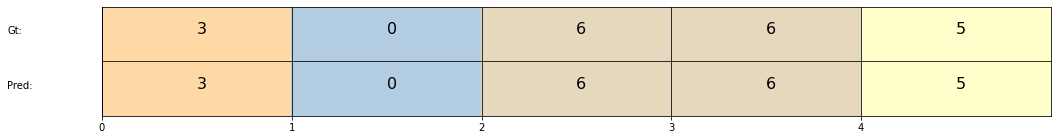

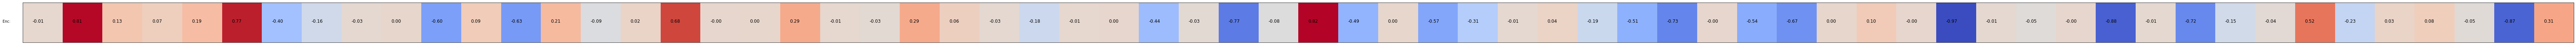

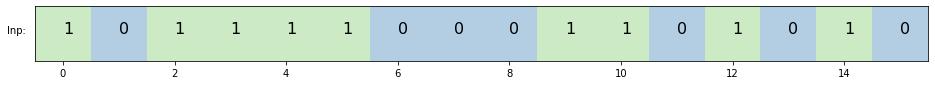

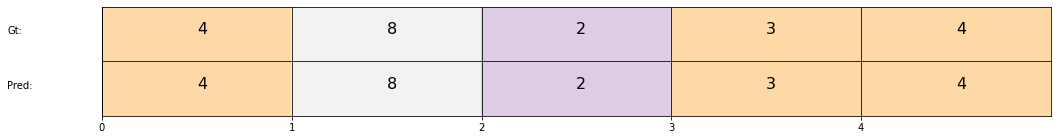

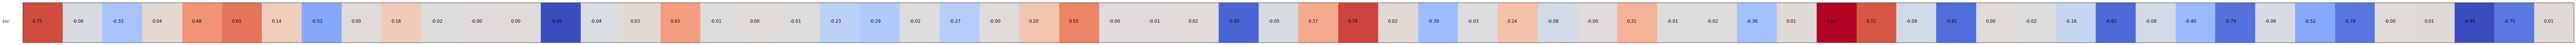

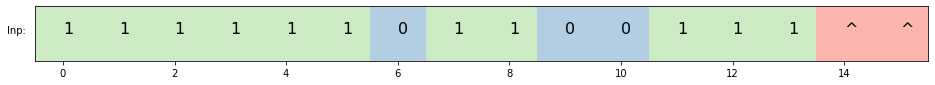

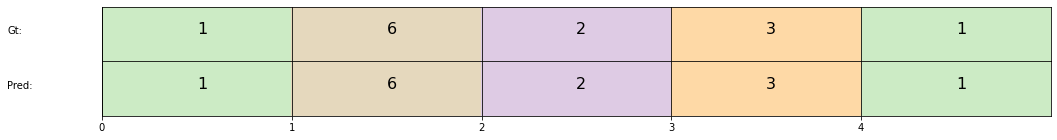

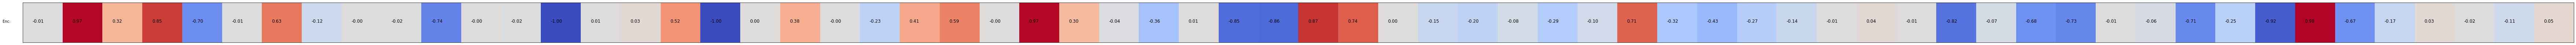

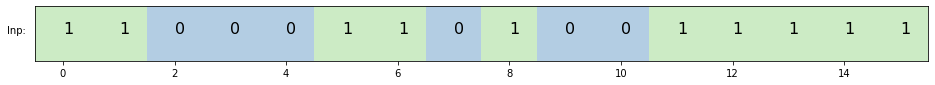

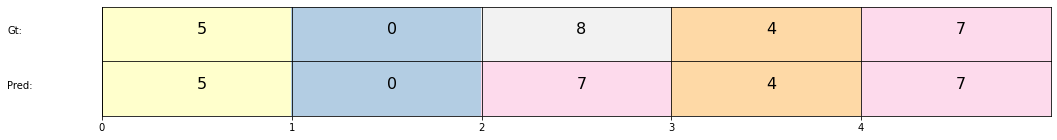

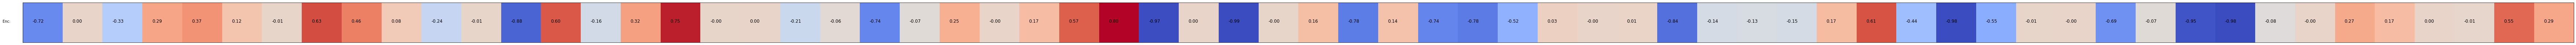

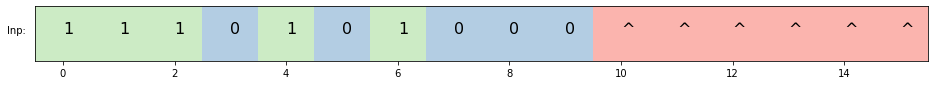

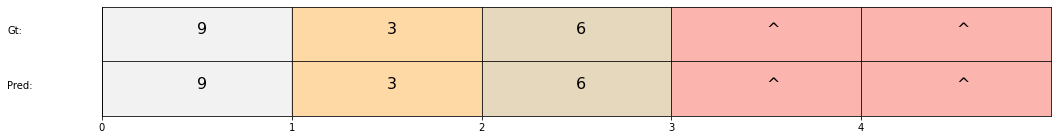

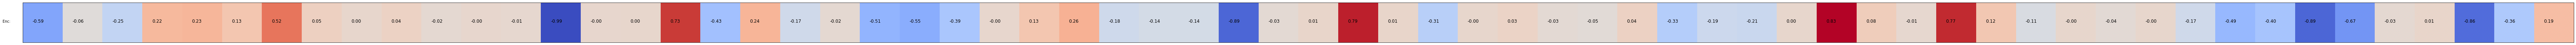

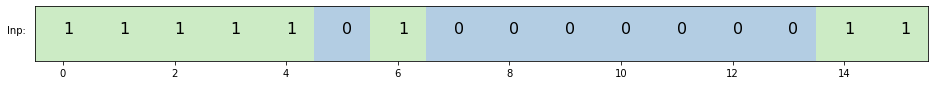

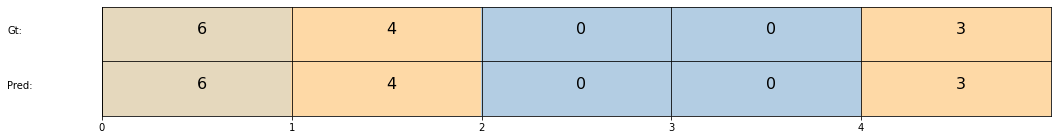

In [31]:
for idx, row in inference_log.iterrows():
    fig = plt.figure(figsize=(128, 2))
    for i in range(0, row['encoding'].squeeze().shape[0]):
        plt.text(i-0.25, 0, '{:.2f}'.format(row['encoding'][0,i]), fontsize=12)
    plt.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelleft=False)
    plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            top=False,      # ticks along the bottom edge are off
            bottom=False,         # ticks along the top edge are off
            labelbottom=False)
    plt.imshow(row['encoding'], cmap='coolwarm')
    plt.text(-1, 0, 'Enc:')
    plt.show()
    
    inp = row['input_seq']
    inp_cod = []
    fig = plt.figure(figsize=(16, 1))
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False)
    for c in inp:
        inp_cod.append(output_alphabet.find(c))
    inp_cod = np.array(inp_cod)[None, ...]
    plt.imshow(inp_cod,cmap='Pastel1', aspect = "auto",vmin=0,vmax=11)
    for i in range(0, max_len_input):
        plt.text(i, 0, inp[i], fontsize=16)
    plt.text(-1, 0, 'Inp:')
    fig, axs= draw_vector(row['target_seq'], row['predict'])
    plt.show()

Используемые материалы:     
[1] [lena-voita.github.io - Seq2Seq](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html)    
[2] [PyTorch Seq2Seq Tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)     
[3] [Wikipedia - One-hot](https://en.wikipedia.org/wiki/One-hot)     